In [1]:
import numpy as np
import matplotlib.pyplot as plt
import progressbar

np.random.seed(0)

# Lab 4

## Part 1

### Incremental averange calculating:

$$Q_{t+1}(a)=Q_t(a)+\frac{1}{c_{t}(a)}\cdot\left(r_{t+1}-Q_t(a)\right)$$

## Generating actions:

In [2]:
class Action:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def get_reward(self):
        return np.random.normal(self.mu, self.sigma)

In [3]:
rounds_cnt = 1000
actions_cnt = 20
sigma = 1

mus = np.random.normal(0, 1, actions_cnt)
actions = list(map(lambda mu: Action(mu, sigma), mus))

print("Actions rewards expectations: ", mus)

Actions rewards expectations:  [ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574]


In [4]:
optimal_result = mus.max() * rounds_cnt
print(optimal_result)

2240.8931992


## Graph of average final reward depending on params:

In [5]:
def show_results(params, results, xlabel):
    plt.plot(params, results)
    plt.ylabel('reward expectation', fontsize=13)
    plt.ylim(0, optimal_result)
    plt.xlabel(xlabel, fontsize=30)
    plt.show()

## Graph of average reward on step t:

In [6]:
def show_average_game(history):
    print('Averange final reward: ', history.max())
    plt.plot(history)
    plt.ylabel('average reward', fontsize=13)
    plt.xlabel('t')
    plt.ylim(0, optimal_result)
    plt.show()

## Greedy strategy

In [7]:
class GreedyStrategy:
    def __init__(self, initial_q=0):
        self.initial_q = initial_q
        self.q = np.ones(actions_cnt) * initial_q
        self.cnt = np.zeros(actions_cnt)
        
    def reset(self):
        self.q = np.ones(actions_cnt) * self.initial_q
        self.cnt = np.zeros(actions_cnt)
    
    def choose_action(self):
        best_actions = np.flatnonzero(self.q == self.q.max())
        return np.random.choice(best_actions)
    
    def run(self, actions):
        history = []
        full_reward = 0
        self.t = 0
        while self.t < rounds_cnt:
            action = self.choose_action()
            reward = actions[action].get_reward()
            self.cnt[action] += 1
            self.q[action] += (reward - self.q[action]) / self.cnt[action]
            full_reward += reward
            history.append(full_reward)
            self.t += 1
        return np.array(history)

In [8]:
def average_history(strategy, games=1000, printable=True):
    history = np.zeros(rounds_cnt)
    
    generator = range(games)
    if printable:
        bar = progressbar.ProgressBar()
        generator = bar(generator)
        
    for i in generator:
        history += strategy.run(actions) / games
        strategy.reset()
        
    return history

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:12 Time: 0:00:12


Averange final reward:  2040.28195739


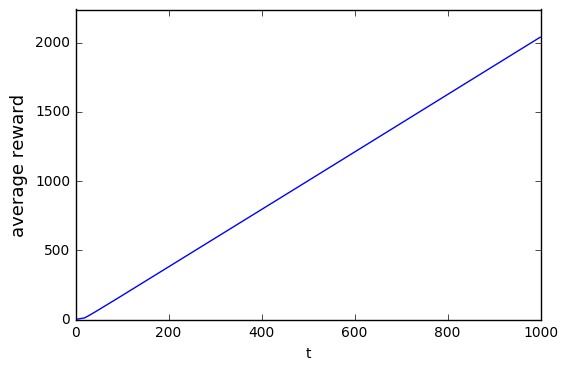

In [9]:
strategy = GreedyStrategy(initial_q=5)
greedy_history = average_history(strategy, games=1000)

show_average_game(greedy_history)

Изначально $\forall a\ Q(a)=5$. Значение подобрано так, чтобы жадный алгоритм почти наверняка изучил все действия, прежде чем выбрать наилучшее.

Главный недостаток алгоритма - зависимость от начальных параметров.

Если о распределениях ничего неизвестно, придется сыграть несколько игр, чтобы найти достаточно большое начальное значение.

# $\varepsilon$-Greedy strategy

In [10]:
class EGreedyStrategy(GreedyStrategy):
    def __init__(self, initial_q=0, epsilon=0):
        self.initial_q = initial_q
        self.epsilon = epsilon
        self.q = np.ones(actions_cnt) * initial_q
        self.cnt = np.zeros(actions_cnt)
    
    def choose_action(self):
        best_actions = np.flatnonzero(self.q == self.q.max())
        gr_choice = np.random.choice(best_actions)
        exp_choice = np.random.randint(actions_cnt)
        probabilities = [1 - self.epsilon, self.epsilon]
        return np.random.choice([gr_choice, exp_choice], p=probabilities)

Здесь $Q(a)$ инициализируется нулями, так как если подбирать большие значения, как в предыдущей стратегии, то $\varepsilon$-стратегия теряет смысл.

## Optimizing $\varepsilon$

In [11]:
def evaluate_params(Strategy, params, games=1000):
    strategies = list(map(Strategy, params))
    results = []
    bar = progressbar.ProgressBar()
    for st in bar(strategies):
        history = average_history(st, games, printable=False)
        results.append(history[-1])
    return results

100% (20 of 20) |#########################| Elapsed Time: 0:11:36 Time: 0:11:36


Optimal epsilon:  0.0921052631579


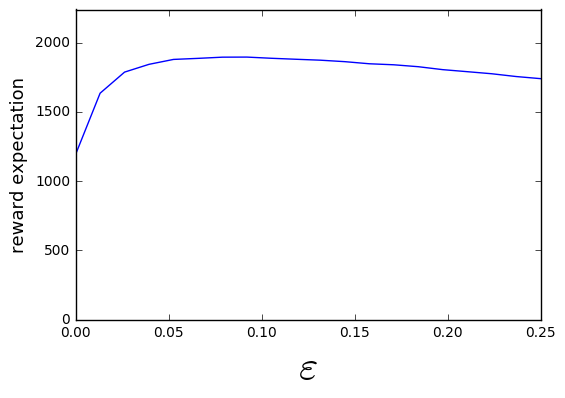

In [13]:
def Strategy(epsilon):
    return EGreedyStrategy(epsilon=epsilon)

epsilons = np.linspace(0.0, 0.25, num=20)
e_greedy_results = evaluate_params(Strategy, epsilons, games=1000)

egreedy_epsilon_opt = epsilons[np.argmax(e_greedy_results)]
print("Optimal epsilon: ", egreedy_epsilon_opt)

show_results(epsilons, e_greedy_results, r'$\varepsilon$')

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:39 Time: 0:00:39


Averange final reward:  1893.20857167


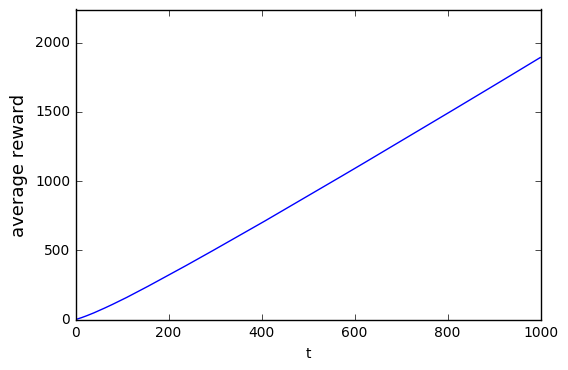

In [14]:
st = EGreedyStrategy(epsilon=egreedy_epsilon_opt)
egreedy_history = average_history(st, games=1000)

show_average_game(egreedy_history)

# Softmax Strategy

При $\varepsilon\to 0$ стратегия превращается в обычную жадную, при $\varepsilon\to\infty$ действие выбирается случайно.

In [15]:
def softmax(x):
    e_x = np.exp(x - x.max())
    return e_x / e_x.sum()

In [16]:
class SoftmaxStrategy(EGreedyStrategy):    
    def choose_action(self):
        return np.random.choice(np.arange(actions_cnt), p=softmax(self.q / self.epsilon))

100% (30 of 30) |#########################| Elapsed Time: 0:16:22 Time: 0:16:22


Optimal epsilon:  0.29724137931


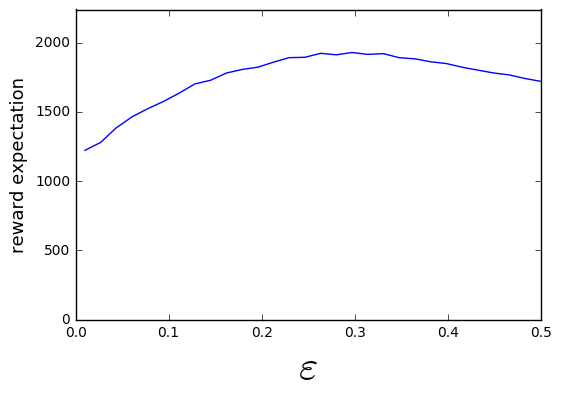

In [17]:
def Strategy(epsilon):
    return SoftmaxStrategy(epsilon=epsilon)

epsilons = np.linspace(0.01, 0.5, num=30)
softmax_results = evaluate_params(Strategy, epsilons, games=1000)

softmax_epsilon_opt = epsilons[np.argmax(softmax_results)]
print("Optimal epsilon: ", softmax_epsilon_opt)

show_results(epsilons, softmax_results, r'$\varepsilon$')

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:37 Time: 0:00:37


Averange final reward:  1934.9163795


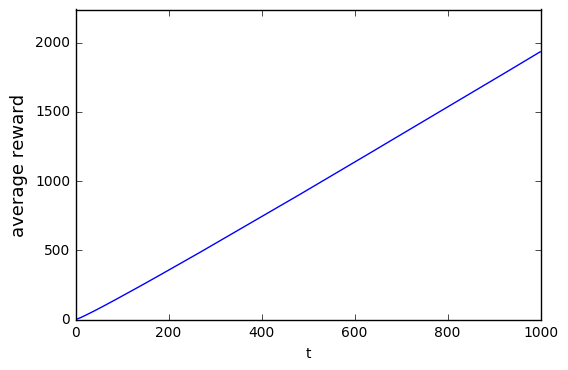

In [18]:
st = SoftmaxStrategy(epsilon=softmax_epsilon_opt)
softmax_history = average_history(st, games=1000)

show_average_game(softmax_history)

# Upper confidence bound

In [19]:
class UCBStrategy(EGreedyStrategy):        
    def choose_action(self):
        if self.t < actions_cnt:
            unplayed_actions = np.flatnonzero(self.cnt == 0)
            return np.random.choice(unplayed_actions)
        potential = self.q + self.epsilon * np.sqrt(2 * np.log(self.t) / self.cnt)
        best_actions = np.flatnonzero(potential == potential.max())
        return np.random.choice(best_actions)

100% (40 of 40) |#########################| Elapsed Time: 0:12:02 Time: 0:12:02


Optimal epsilon:  0.461538461538


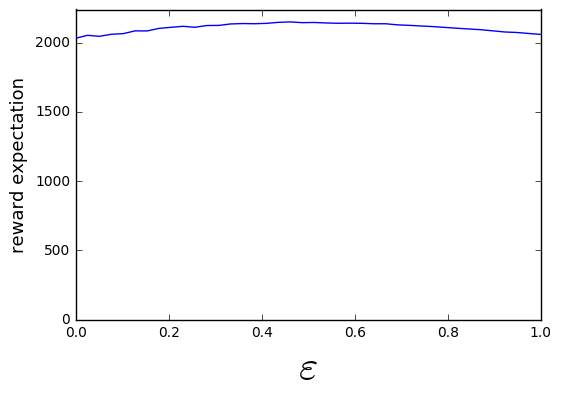

In [20]:
def Strategy(epsilon):
    return UCBStrategy(epsilon=epsilon)

epsilons = np.linspace(0.0, 1.0, num=40)
results = evaluate_params(Strategy, epsilons, games=1000)

ucb_epsilon_opt = epsilons[np.argmax(results)]
print("Optimal epsilon: ", ucb_epsilon_opt)

show_results(epsilons, results, r'$\varepsilon$')

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:19 Time: 0:00:19


Averange final reward:  2149.68500706


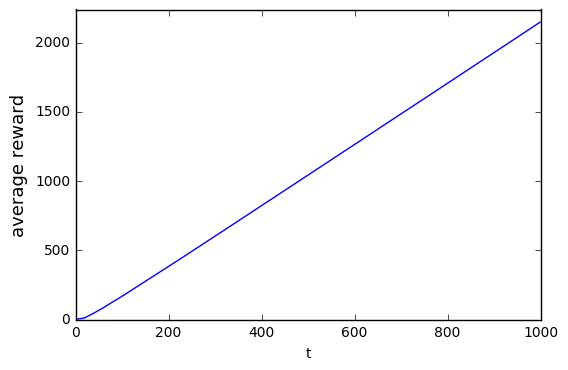

In [21]:
st = UCBStrategy(epsilon=ucb_epsilon_opt)
ucb_history = average_history(st, games=1000)

show_average_game(ucb_history)

# Gradient bandit policy

In [22]:
class GradientBanditStrategy:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.average_reward = 0
        self.h = np.zeros(actions_cnt)
        self.pr = softmax(self.h)
        
    def reset(self):
        self.h = np.zeros(actions_cnt)
        self.average_reward = 0
        self.pr = softmax(self.h)
        
    def choose_action(self):
        return np.random.choice(np.arange(actions_cnt), p=self.pr)
    
    def update(self, chosen_action, reward):
        self.average_reward += self.alpha(self.t) * (reward - self.average_reward)
        for i in range(actions_cnt):
            if i == chosen_action:
                self.h[i] += self.beta * (reward - self.average_reward) * (1 - self.pr[i])
            else:
                self.h[i] -= self.beta * (reward - self.average_reward) * self.pr[i]
        self.pr = softmax(self.h)
        
    def run(self, actions):
        history = []
        full_reward = 0
        self.t = 0
        while self.t < rounds_cnt:
            action = self.choose_action()
            reward = actions[action].get_reward()
            self.update(action, reward)
            full_reward += reward
            history.append(full_reward)
            self.t += 1
        return np.array(history)        

In [23]:
def alpha(t):
    return 1 / (t + 1)

100% (20 of 20) |#########################| Elapsed Time: 0:15:40 Time: 0:15:40


Optimal beta:  0.128205128205


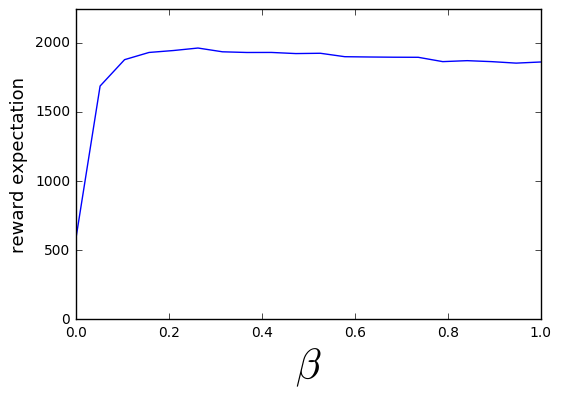

In [24]:
def Strategy(beta):
    return GradientBanditStrategy(alpha=alpha, beta=beta)

betas = np.linspace(0.0, 1.0, num=20)
results = evaluate_params(Strategy, betas, games=1000)

grad_beta_opt = epsilons[np.argmax(results)]
print("Optimal beta: ", grad_beta_opt)

show_results(betas, results, r'$\beta$')

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:52 Time: 0:00:52


Averange final reward:  1909.62538619


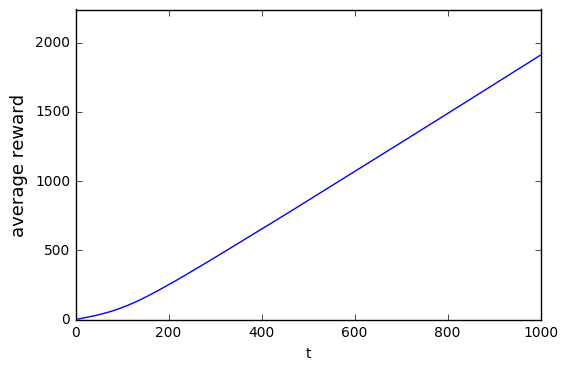

In [25]:
st = GradientBanditStrategy(alpha, grad_beta_opt)
grad_history = average_history(st, games=1000)

show_average_game(grad_history)

# Strategies comparison

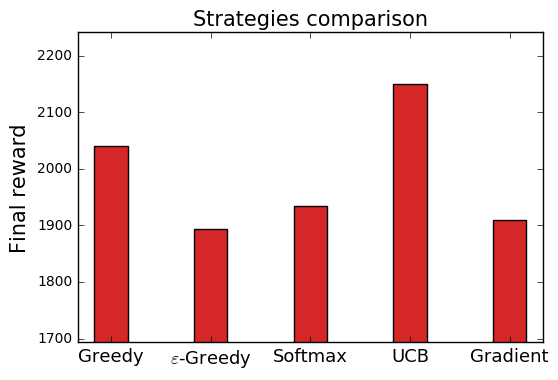

In [26]:
histories = [greedy_history, egreedy_history, softmax_history, ucb_history, grad_history]
results = np.array(list(map(np.max, histories)))
positions_x = np.arange(len(histories)) * 3
width = 1
p1 = plt.bar(positions_x + 0.5, results, width, color='#d62728')

plt.ylabel('Final reward', fontsize=15)
plt.ylim(results.min()-200, optimal_result)
plt.title('Strategies comparison', fontsize=15)
plt.xticks(positions_x + 1, ('Greedy', r'$\varepsilon$-Greedy', 'Softmax', 'UCB', 'Gradient'), fontsize=13)
plt.show()

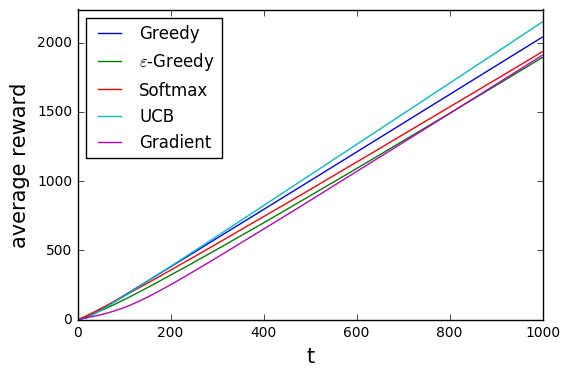

In [27]:
plt.plot(greedy_history, label='Greedy')
plt.plot(egreedy_history, label=r'$\varepsilon$-Greedy')
plt.plot(softmax_history, label='Softmax')
plt.plot(ucb_history, label='UCB')
plt.plot(grad_history, label='Gradient')
plt.xlabel('t', fontsize=15)
plt.ylabel('average reward', fontsize=15)
plt.ylim(0, optimal_result)
plt.legend(loc=2)
plt.show()

# Part 2

# Markov decison process

1. Пример MDP: шахматы.
2. Пример игры, не моделируемой с помощью MDP: карточные игры - на исход игры влияет то, какие карты были использованы, но текущее состояние не может их описывать, так как зачастую они неизвестны.
3. * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t] = \sum_{s_{t+1}}\sum_{r_{t+1}}r_{t+1}\cdot p(s_{t+1}, r_{t+1}|s_t, a_t)$
   * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \} = \sum_{r_{t+1}}p(s_{t+1}, r_{t+1}|s_t, a_t)$
   * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t]= \sum_{r_{t+1}}r_{t+1}\cdot \frac{p(s_{t+1}, r_{t+1}|s_t,a_t)}{p(s_{t+1} | s_t, a_t)}$

Смоделированная среда:

100 состояний. Действия: 0, 1.

Совершив действие 0 в состоянии $s$, среда перебрасывает в состояние $s-1$, если $s > 0$, иначе в $s$. Совершив действие 1 - в состоянии $s$ среда переносит в состояние $s+1$, если $s < 99$, иначе в $s$.

Награды: 1 при совершении действия 1 в состоянии 99, 0 иначе.

In [28]:
states_cnt = 100
actions_cnt = 2
rewards_cnt = 2

In [29]:
class Environment:
    def __init__(self):
        self.pr = np.zeros((states_cnt, actions_cnt, states_cnt, rewards_cnt))
        for s in range(states_cnt):
            if s == 0:
                self.pr[s][0][s][0] = 1
                self.pr[s][1][s + 1][0] = 1
            elif s == 99:
                self.pr[s][0][s - 1][0] = 1
                self.pr[s][1][s][1] = 1
            else:
                self.pr[s][0][s - 1][0] = 1
                self.pr[s][1][s + 1][0] = 1
        self.state = 0
            
    def get_probability(self, s_new, reward, s, a):
        if s_new in range(states_cnt):
            return self.pr[s][a][s_new][reward]
        else:
            return 0

In [30]:
class PolicyIterationStrategy:
    def __init__(self, gamma, env):
        self.v = np.random.uniform(0, 1, (states_cnt))
        self.q = np.random.uniform(0, 1, (states_cnt, actions_cnt))
        self.env = env
        self.gamma = gamma
        self.iterations_cnt = 0
    
    def calc_q(self, s, a):
        ans = 0
        if a == 0:
            s_new = max(0, s - 1)
        else:
            s_new = min(s + 1, 99)
        for reward in range(rewards_cnt):
            ans += self.env.get_probability(s_new, reward, s, a) * (reward + self.gamma * self.v[s_new])
        return ans
    
    def calc_v(self):
        while True:
            self.iterations_cnt += 1
            for state in range(states_cnt):
                for action in range(actions_cnt):
                    self.q[state][action] = self.calc_q(state, action)
            updated_v = np.array(list(map(np.max, self.q)))
            if np.max(np.abs(self.v - updated_v)) < 1e-50:
                break
            self.v = updated_v
    
    def get_optimal_policy(self):
        self.iterations_cnt = 0
        policy = np.zeros(100)
        while True:
            self.iterations_cnt += 1
            self.calc_v()
            updated_policy = np.array(list(map(np.argmax, self.q)))
            if (policy == updated_policy).all():
                return policy
            policy = updated_policy

In [31]:
env = Environment()
gamma = 0.5
st1 = PolicyIterationStrategy(gamma, env)
policy = st1.get_optimal_policy()

print("Optimal policy:", policy)
print("Iterations: ", st1.iterations_cnt)

Optimal policy: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Iterations:  157


In [32]:
class ValueInterationStrategy(PolicyIterationStrategy):
    def get_optimal_policy(self):
        self.iterations_cnt = 0
        policy = np.zeros(100)
        step = 0
        while True:
            # one policy iteration + one value iteration
            self.iterations_cnt += 2
            for state in range(states_cnt):
                for action in range(actions_cnt):
                    self.q[state][action] = self.calc_q(state, action)
            self.v = np.array(list(map(np.max, self.q)))
            updated_policy = np.array(list(map(np.argmax, self.q)))
            if (policy == updated_policy).all():
                return policy
            policy = updated_policy

In [33]:
st2 = ValueInterationStrategy(1, env)
policy = st2.get_optimal_policy()
print("Optimal policy:", policy)
print("Iterations: ", st2.iterations_cnt)

Optimal policy: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Iterations:  202


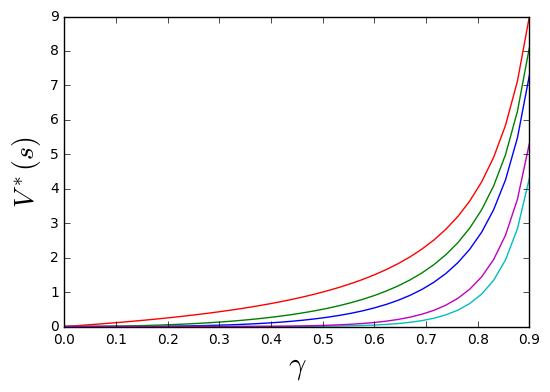

In [34]:
gammas_cnt = 40
gammas = np.linspace(0, 0.9, gammas_cnt)
states = np.random.choice(np.arange(90, 100), 5)
values = np.zeros((5, gammas_cnt))

for i in range(gammas_cnt):
    strategy = PolicyIterationStrategy(gammas[i], env)
    strategy.get_optimal_policy()
    for j in range(5):
        values[j][i] = strategy.v[states[j]]

for i in range(5):
    plt.plot(gammas, values[i])

plt.xlim(0, 0.9)
plt.ylabel(r'$V^*(s)$', fontsize=20)
plt.xlabel(r'$\gamma$', fontsize=22)
plt.show()

$V^*_{s}(\gamma)$ растет экспонециально быстро, при $\gamma\geq1$ не сходится.

# Part 3

In [4]:
def board_to_int(board):
    x = 0
    for i in range(9):
        x *= 3
        x += board.flat[8 - i]
    return x

def int_to_board(x):
    board = np.zeros((3, 3), 'int')
    for i in range(9):
        board.flat[i] = x % 3
        x //= 3
    return board

In [5]:
def calc_allowed_actions(state):
    board = int_to_board(state)
    return np.flatnonzero(board == 0)

In [6]:
states_count = 3 ** 9
allowed_actions = list(map(calc_allowed_actions, range(states_count)))
base_states = np.repeat(-1, states_count)
transforms = np.empty(states_count, dtype=tuple)

In [7]:
def find_similar_states(base_state):
    board = int_to_board(base_state)
    for i in range(4):
        state = board_to_int(board)
        base_states[state] = base_state
        transforms[state] = np.array((i, 0))
        board_reversed = np.fliplr(board)
        reversed_state = board_to_int(board_reversed)
        transforms[reversed_state] = np.array((i, 1))
        base_states[reversed_state] = base_state
        board = np.rot90(board)
        
        
for state in range(states_count):
    if base_states[state] == -1:
        find_similar_states(state)

In [8]:
class Judge:
    def __init__(self):
        self.DRAW = 0
        self.PLAYING = 3
        self.results = list(map(self.calc_game_status, range(states_count)))

    def get_board_lines(self, state):
        board = int_to_board(state)
        board_rotated = np.rot90(board)
        diag1 = np.diag(board)
        diag2 = np.diag(board_rotated)
        return np.vstack([board, board_rotated, diag1, diag2])
        
    def line_winner(self, line):
        for player in range(1, 3):
            if (line == player).all():
                return player
        return 0

    def calc_game_status(self, state):
        all_lines = self.get_board_lines(state)
        for line in all_lines:
            if self.line_winner(line):
                return self.line_winner(line)
        return self.PLAYING if len(allowed_actions[state]) else self.DRAW
    
    def get_result(self, state):
        return self.results[state]

In [9]:
judge = Judge()

# SARSA

In [10]:
class AgentSARSA:
    def __init__(self, alpha=0.1, epsilon=0.01, gamma=0.5):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q = np.zeros((states_count, 9))
        self.count = np.zeros((states_count, 9), 'int')
        self.prev_state = 0
        self.prev_action = 0
        
    def choose_action(self, state):
        q = self.q[state].take(allowed_actions[state])
        indices_of_best = np.flatnonzero(q == q.max())
        best_actions = allowed_actions[state].take(indices_of_best)
        good_choice = np.random.choice(best_actions)
        rand_choice = np.random.choice(allowed_actions[state])
        return np.random.choice([good_choice, rand_choice], p=[1 - self.epsilon, self.epsilon])
        
    def get_action(self, state):
        action = self.choose_action(state)
        self.count[state][action] += 1
        if self.prev_state != -1:
            self.q[self.prev_state][self.prev_action] += self.alpha * (self.gamma * self.q[state][action]
                                                                       - self.q[self.prev_state][self.prev_action])
        self.prev_state = state
        self.prev_action = action
        return action
    
    def put_reward(self, reward):
        self.q[self.prev_state][self.prev_action] += self.alpha * (reward
                                                                   - self.q[self.prev_state][self.prev_action])
        self.state = -1
        
    def get_action_without_updating(self, state):
        q = self.q[state].take(allowed_actions[state])
        indices_of_best = np.flatnonzero(q == q.max())
        best_actions = allowed_actions[state].take(indices_of_best)
        return np.random.choice(best_actions)

# Q-learning

In [11]:
class AgentQ(AgentSARSA):
    def get_action(self, state):
        action = self.choose_action(state)
        self.count[state][action] += 1
        
        if self.prev_state != -1:
            q_max = self.q[state].take(allowed_actions[state]).max()
            self.q[self.prev_state][self.prev_action] += self.alpha * (self.gamma * q_max
                                                                       - self.q[self.prev_state][self.prev_action])
        self.prev_state = state
        self.prev_action = action
        return action

In [12]:
class Simulator:
    def __init__(self, judge, agents, printable=True):
        self.agents = agents
        self.judge = judge
        self.printable = printable
        
    def play_games(self, games_cnt):
        
        generator = range(games_cnt)
        if self.printable:
            bar = progressbar.ProgressBar()
            generator = bar(generator)
            
        for i in generator:
            state = 0
            player = 0
            while self.judge.get_result(state) == 3:
                action = self.agents[player].get_action(state)
                state += (player + 1) * 3 ** action
                state = base_states[state]
                player = (player + 1) % 2
                
            winner = self.judge.get_result(state)
            if winner:
                self.agents[winner - 1].put_reward(100)
                self.agents[1 - (winner - 1)].put_reward(-100)
            else:
                for agent in self.agents:
                    agent.put_reward(1)

In [13]:
class RandomAgent:
    def get_action_without_updating(self, state):
        return np.random.choice(allowed_actions[state])

In [14]:
class Checker:
    def __init__(self, agents):
        self.tic_agent, self.tac_agent = agents
        self.rand_agent = RandomAgent()
        
    def get_wins_percent(self, agents, games_cnt):
        wins_count = np.zeros(2)
        for i in range(games_cnt):
            state = 0
            player = 0
            while judge.get_result(state) == 3:
                action = agents[player].get_action_without_updating(state)
                state += (player + 1) * 3 ** action
                player = (player + 1) % 2
                state = base_states[state]
                
            winner = judge.get_result(state)
            if winner:
                wins_count[winner - 1] += 1
            else:
                wins_count += 1
        return wins_count / games_cnt
    
    def get_tic_wins_percent(self, games_cnt):
        p = self.get_wins_percent([self.tic_agent, self.rand_agent], games_cnt)
        return p[0]
        
    def get_tac_wins_percent(self, games_cnt):
        p = self.get_wins_percent([self.rand_agent, self.tac_agent], games_cnt)
        return p[1]
    
    def get_wins_percentage(self, games_cnt):
        p1 = self.get_tic_wins_percent(games_cnt)
        p2 = self.get_tac_wins_percent(games_cnt)
        return np.array([p1, p2])

In [20]:
def train(agents):
    checker = Checker(agents)
    simulator = Simulator(judge, agents, printable=False)
    wins_percentage = np.zeros(2)
    history = []
    while not((wins_percentage == 1).all()):
        simulator.play_games(1000)
        wins_percentage = checker.get_wins_percentage(10000)
        print('quality: ', wins_percentage)
        history.append(wins_percentage)
    return np.array(history)

## Sarsa and Q-learning convergence comparison

In [24]:
alpha = 0.1
epsilon = 0.5
gamma = 0.2

SARSA_agents = AgentSARSA(alpha, epsilon, gamma), AgentSARSA(alpha, epsilon, gamma)
Q_agents = AgentQ(alpha, epsilon, gamma), AgentQ(alpha, epsilon, gamma)

Q_quality = train(Q_agents)[:, 1]
SARSA_quality = train(SARSA_agents)[:, 1]

quality:  [ 0.9898  0.8531]
quality:  [ 0.993   0.9923]
quality:  [ 0.9976  0.9978]
quality:  [ 0.9977  1.    ]
quality:  [ 1.  1.]
quality:  [ 1.      0.9476]
quality:  [ 1.      0.8291]
quality:  [ 1.      0.9594]
quality:  [ 1.      0.9352]
quality:  [ 1.      0.9834]
quality:  [ 1.      0.9657]
quality:  [ 1.      0.9185]
quality:  [ 1.     0.953]
quality:  [ 1.      0.9772]
quality:  [ 1.      0.9745]
quality:  [ 1.      0.9485]
quality:  [ 1.      0.9835]
quality:  [ 1.      0.9576]
quality:  [ 1.      0.9499]
quality:  [ 1.      0.9802]
quality:  [ 1.      0.9964]
quality:  [ 1.  1.]


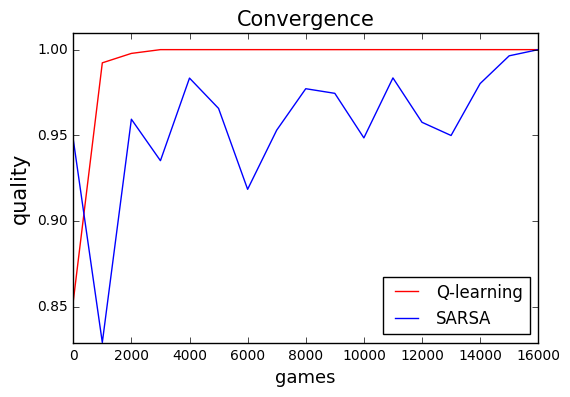

In [25]:
n1, n2 = list(map(len, [Q_quality, SARSA_quality]))
n = max(n1, n2)

Q_quality = np.append(Q_quality, np.repeat(1, n - n1))
SARSA_quality = np.append(SARSA_quality, np.repeat(1, n - n2))
steps = np.arange(n) * 1000

plt.plot(steps, Q_quality, color='r', label='Q-learning')
plt.plot(steps, SARSA_quality, color='b', label='SARSA')

plt.title('Convergence', fontsize=15)
plt.ylabel('quality', fontsize=15)
plt.xlabel('games', fontsize=13)
plt.legend(loc=4)
plt.ylim(min(Q_quality.min(), SARSA_quality.min()), 1.01)
plt.show()

In [26]:
class PlayingInterface:
    def __init__(self, agents, role=1):
        self.judge = judge
        if role == 1:
            self.agent = agents[1]
        else:
            self.agent = agents[0]
        self.agent.epsilon = 0
        self.agent_role = 3 - role
        self.role = role        
        
    def start(self):
        transform = []
        res = 3
        state = 0
        if self.role == 2:
            action = self.agent.get_action(state)
            state += self.agent_role * 3 ** action
        self.print_board(state)
        
        while res == 3:
            y, x = list(map(int, input().split()))
            action = y * 3 + x
            state += self.role * 3 ** action
            res = self.judge.get_result(state)
            
            transform = transforms[state]
            state = base_states[state]
            
            if res == 3:
                action = self.agent.get_action_without_updating(state)
                state += self.agent_role * 3 ** action
                res = self.judge.get_result(state)
            
            board = int_to_board(state)
            board = np.rot90(board, transform[0])
            if transform[1]:
                board = np.fliplr(board)
            state = board_to_int(board)
            
            self.print_board(state)

        if res == self.role:
            print("You won")
        elif res == self.agent_role:
            print("You lost")
        elif res == 0:
            print("Draw")
        
        print('Restart? (y/n)')
        ans = input()
        if ans == 'y':
            self.start()
        
    def print_board(self, state):
        b = int_to_board(state)
        print(b)

In [32]:
Q_agents = AgentQ(alpha, epsilon, gamma), AgentQ(alpha, epsilon, gamma)

sim = Simulator(judge, Q_agents)
sim.play_games(20000)

100% (20000 of 20000) |###################| Elapsed Time: 0:00:06 Time: 0:00:06


In [33]:
p = PlayingInterface(Q_agents, 2)
p.start()

[[0 0 0]
 [0 0 1]
 [0 0 0]]
0 0
[[2 0 1]
 [0 0 1]
 [0 0 0]]
2 2
[[2 0 1]
 [0 1 1]
 [0 0 2]]
1 0
[[2 0 1]
 [2 1 1]
 [1 0 2]]
You lost
Restart? (y/n)
y
[[0 0 0]
 [0 0 1]
 [0 0 0]]
1 1
[[0 0 0]
 [0 2 1]
 [0 0 1]]
0 2
[[0 0 2]
 [0 2 1]
 [1 0 1]]
2 1
[[0 1 2]
 [0 2 1]
 [1 2 1]]
0 0
[[2 1 2]
 [1 2 1]
 [1 2 1]]
Draw
Restart? (y/n)
n
